In [22]:
import pylab as p
import numpy as np
import pandas as pd
import seaborn as sns
import pyspikelib.utils as spkutil
import pyspikelib.mpladeq as mpladeq

from pathlib import Path

sns.set(font_scale=1.7, style='ticks')
mpladeq.beautify_mpl()

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [24]:
np.random.seed(15)

In [29]:
! ls ../data/*

../data/data_download_link.md  ../data/README.md   ../data/wake.parq
../data/fcx1_data.tar	       ../data/sleep.parq


In [30]:
! cd ../data; tar -xvf ../data/fcx1_data.tar ./

./README.md
./sleep.parq.gz
./wake.parq.gz


In [9]:
! gzip -df ../data/sleep.parq.gz; gzip -df ../data/wake.parq.gz 

In [8]:
datapath = Path('../data')

In [9]:
wake_data = spkutil.load_parquet(datapath / 'wake.parq')
sleep_data = spkutil.load_parquet(datapath / 'sleep.parq')

In [10]:
data = {}

data['wake_train'], data['wake_test'] = spkutil.split_by_spikes(wake_data, ratio=0.5)
data['sleep_train'], data['sleep_test'] = spkutil.split_by_spikes(sleep_data, ratio=0.5)

Text(0, 0.5, 'ISI value, ms')

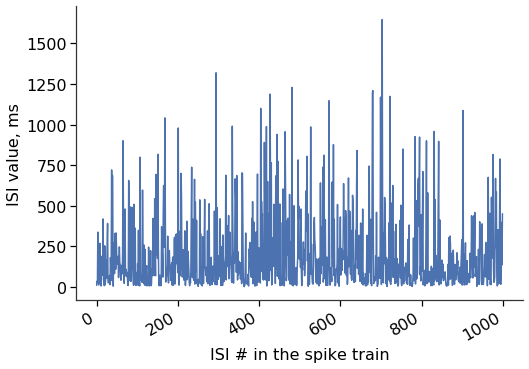

In [13]:
p.plot(data['wake_train']['series'][5][:1000])

mpladeq.prettify()
p.xlabel('ISI # in the spike train')
p.ylabel('ISI value, ms')

In [16]:
window_size = 100
step_size = 100
total_samples = 5000

crop_data = {}
for key in data:
    crop_data[key] = spkutil.crop_isi_samples(data[key],
                                              window_size=window_size,
                                              step_size=step_size,
                                              total_samples=total_samples)

In [17]:
[(key, crop_data[key]['series'].shape) for key in crop_data]

[('wake_train', (5000, 100)),
 ('wake_test', (5000, 100)),
 ('sleep_train', (5000, 100)),
 ('sleep_test', (5000, 100))]

In [18]:
tsdata = {}
for key in data:
    tsdata[key] = spkutil.tsfresh_vectorize(crop_data[key]['series'],
                                            feature_dict='distribution_features',
                                            n_jobs=24)

Feature Extraction: 100%|██████████| 120/120 [00:05<00:00, 23.45it/s]


In [19]:
tsdata['wake_train'].head(10)

variable,value__abs_energy,value__count_above_mean,value__count_below_mean,value__kurtosis,value__large_standard_deviation__r_0.05,value__large_standard_deviation__r_0.1,value__large_standard_deviation__r_0.15000000000000002,value__large_standard_deviation__r_0.2,value__large_standard_deviation__r_0.25,value__large_standard_deviation__r_0.3,...,value__symmetry_looking__r_0.6000000000000001,value__symmetry_looking__r_0.6500000000000001,value__symmetry_looking__r_0.7000000000000001,value__symmetry_looking__r_0.7500000000000001,value__symmetry_looking__r_0.8,value__symmetry_looking__r_0.8500000000000001,value__symmetry_looking__r_0.9000000000000001,value__symmetry_looking__r_0.9500000000000001,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,1.329667e+06,26.0,74.0,33.947574,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9069.069350,1.0
1,4.722175e+05,35.0,65.0,14.622472,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2701.402491,1.0
2,9.689472e+05,35.0,65.0,9.961025,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4167.050181,1.0
3,5.480893e+06,36.0,64.0,1.779285,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,24958.418371,1.0
4,3.416714e+07,35.0,65.0,15.758712,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,204490.408755,1.0
5,2.790326e+06,22.0,78.0,63.557769,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,23002.415364,1.0
6,6.779223e+04,35.0,65.0,2.710672,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,237.006346,1.0
7,1.680773e+06,30.0,70.0,4.939950,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,9113.280776,1.0
8,2.274120e+05,36.0,64.0,26.008830,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1203.553845,1.0


In [25]:
samples = 4500
indices = np.random.choice(total_samples, samples)

X_train = pd.concat([tsdata['wake_train'].iloc[indices, :], tsdata['sleep_train'].iloc[indices, :]])
y_train = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

X_test = pd.concat([tsdata['wake_test'].iloc[indices, :], tsdata['sleep_test'].iloc[indices, :]])
y_test = np.array([0] * indices.shape[0] + [1] * indices.shape[0])

In [26]:
X_train, scaler = spkutil.preprocess_tsfresh_features(X_train,
                                                      remove_low_variance=True)

X_test, _ = spkutil.preprocess_tsfresh_features(X_test,
                                                scaler=scaler,
                                                remove_low_variance=True)

X_train, X_test = spkutil.train_test_common_features(X_train, X_test)

In [27]:
forest = RandomForestClassifier(n_estimators=200,
                                random_state=42,
                                n_jobs=-1)


forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [28]:
accuracy_score(y_test, forest.predict(X_test))

0.7252222222222222

In [29]:
importance = pd.DataFrame()
importance['feature'] = X_train.columns.values
importance['importance_score'] = forest.feature_importances_

In [30]:
importance.sort_values(by='importance_score', ascending=False).head(20)

,feature,importance_score
29,value__quantile__q_0.1,0.087680
13,value__quantile__q_0.2,0.073434
33,value__quantile__q_0.30000000000000004,0.056054
10,value__variance,0.053760
4,value__standard_deviation,0.053592
19,value__quantile__q_0.9,0.050468
26,value__quantile__q_0.4,0.044422
15,value__abs_energy,0.043661
27,value__maximum,0.042888
23,value__minimum,0.041333
